In [1]:
import os
import cv2
import numpy
import matplotlib.pyplot as plt
import time
import shutil
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

import warnings
warnings.filterwarnings("ignore")


2025-06-30 14:40:17.987777: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751294418.206244      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751294418.270594      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_dir = '/kaggle/input/blood-cells-image-dataset/bloodcells_dataset'

# List all folders
folders = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]
print('Folders:', folders)



Folders: ['monocyte', 'ig', 'neutrophil', 'basophil', 'lymphocyte', 'erythroblast', 'eosinophil', 'platelet']


In [3]:
data_dir = '/kaggle/input/blood-cells-image-dataset/bloodcells_dataset'
data = [
    (os.path.join(data_dir, folder, file), folder)
    for folder in os.listdir(data_dir)
    if os.path.isdir(os.path.join(data_dir, folder))
    for file in os.listdir(os.path.join(data_dir, folder))
    if os.path.isfile(os.path.join(data_dir, folder, file))
]

# first five entried of the data frame 

df = pd.DataFrame(data, columns=['filepaths', 'labels'])
print(df['labels'].value_counts())
print(df.head())


labels
neutrophil      3329
eosinophil      3117
ig              2895
platelet        2348
erythroblast    1551
monocyte        1420
basophil        1218
lymphocyte      1214
Name: count, dtype: int64
                                           filepaths    labels
0  /kaggle/input/blood-cells-image-dataset/bloodc...  monocyte
1  /kaggle/input/blood-cells-image-dataset/bloodc...  monocyte
2  /kaggle/input/blood-cells-image-dataset/bloodc...  monocyte
3  /kaggle/input/blood-cells-image-dataset/bloodc...  monocyte
4  /kaggle/input/blood-cells-image-dataset/bloodc...  monocyte


#### df.describe() method in the pandas library for Python is used to generate descriptive statistics of a DataFrame

In [4]:
df.describe()

,filepaths,labels
count,17092,17092
unique,17092,8
top,/kaggle/input/blood-cells-image-dataset/bloodc...,neutrophil
freq,1,3329


#### df.info() method in the Pandas library provides a concise summary of a DataFrame

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17092 entries, 0 to 17091
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  17092 non-null  object
 1   labels     17092 non-null  object
dtypes: object(2)
memory usage: 267.2+ KB


### Sample Visualizations

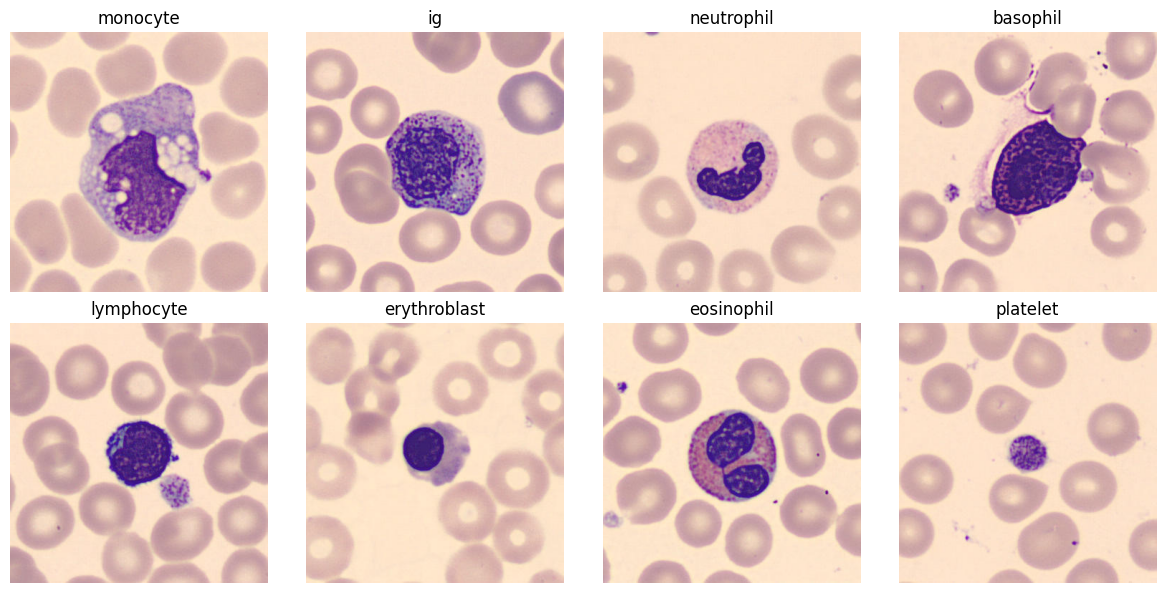

In [6]:
labels = df['labels'].unique()
n = len(labels)
plt.figure(figsize=(12, 6))

for i, label in enumerate(labels):
    img_path = df[df['labels'] == label]['filepaths'].iloc[0]
    img = cv2.imread(img_path)        # Reads image in BGR format
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for correct display
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Class Visualization

<Axes: title={'center': 'Class Distribution'}, xlabel='labels'>

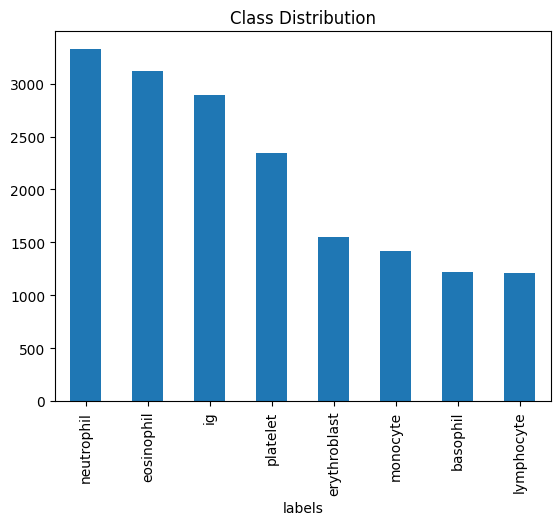

In [7]:
df['labels'].value_counts().plot(kind='bar', title='Class Distribution')


###  Image Size and Aspect Ratio Analysis

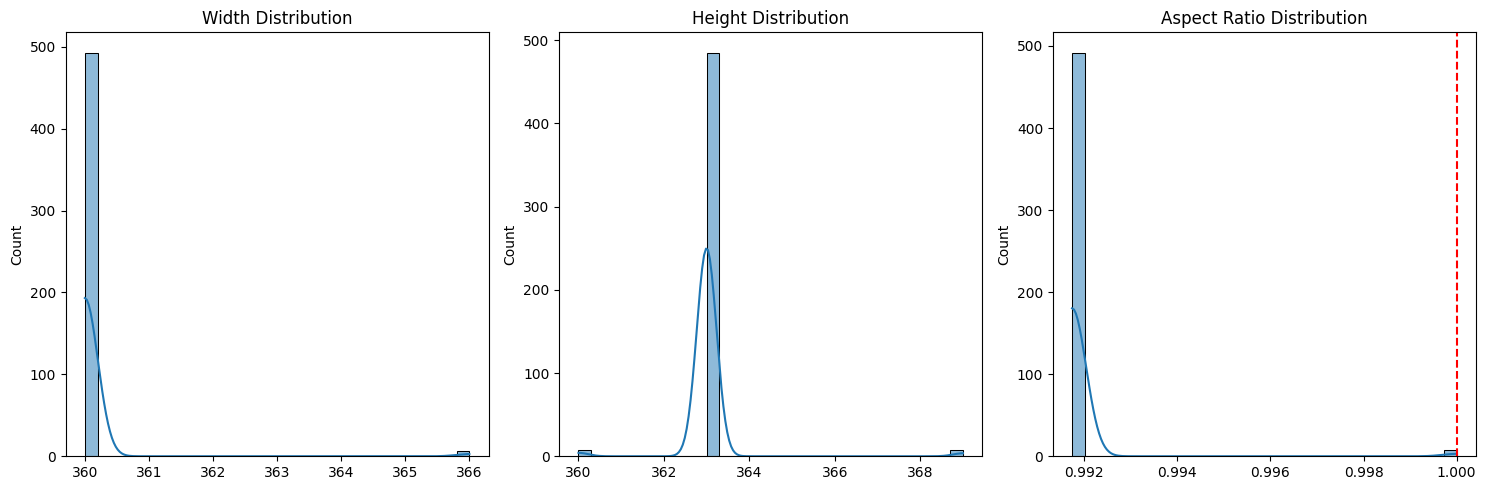

In [8]:
from PIL import Image
import numpy as np

# Collect image dimensions
dimensions = []
for path in df['filepaths'].sample(500):  # Sample for efficiency
    with Image.open(path) as img:
        dimensions.append(img.size)

# Convert to arrays
widths, heights = np.array(dimensions).T

# Plot distributions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(widths, bins=30, kde=True)
plt.title('Width Distribution')

plt.subplot(1, 3, 2)
sns.histplot(heights, bins=30, kde=True)
plt.title('Height Distribution')

plt.subplot(1, 3, 3)
sns.histplot(widths/heights, bins=30, kde=True)
plt.title('Aspect Ratio Distribution')
plt.axvline(1, color='r', linestyle='--')  # Square ratio line

plt.tight_layout()
plt.show()


In [9]:
# # Visualize augmentation effects
# sample_path = df['filepaths'].iloc[0]
# with Image.open(sample_path) as img:
#     img_array = np.expand_dims(np.array(img), 0)

# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# plt.figure(figsize=(15, 5))
# for i in range(5):  # Show 5 augmented versions
#     augmented = next(datagen.flow(img_array))[0].astype('uint8')
#     plt.subplot(1, 5, i+1)
#     plt.imshow(augmented)
#     plt.axis('off')
# plt.suptitle('Data Augmentation Examples', fontsize=16)
# plt.show()


In [10]:
from sklearn.model_selection import train_test_split

# Assume df is your full DataFrame with columns 'filepaths' and 'labels'
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['labels'], random_state=42)


In [11]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)


In [12]:
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(300, 300),
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(300, 300),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 12305 validated image filenames belonging to 8 classes.
Found 1368 validated image filenames belonging to 8 classes.


### Train test val split

In [13]:
# from sklearn.model_selection import train_test_split

# # First, split off the test set
# trainval_df, test_df = train_test_split(df, test_size=0.1, stratify=df['labels'], random_state=42)

# # Then, split trainval into train and validation
# train_df, val_df = train_test_split(trainval_df, test_size=0.2, stratify=trainval_df['labels'], random_state=42)


#### Setting up data generators

In [14]:
# datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# train_gen = datagen.flow_from_dataframe(
#     train_df,
#     x_col='filepaths',
#     y_col='labels',
#     target_size=(224, 224),
#     class_mode='categorical',
#     batch_size=32,
#     subset='training'
# )

# val_gen = datagen.flow_from_dataframe(
#     val_df,
#     x_col='filepaths',
#     y_col='labels',
#     target_size=(224, 224),
#     class_mode='categorical',
#     batch_size=32,
#     subset='validation'
# )


In [15]:
# from tensorflow.keras.applications import EfficientNetB3

# base_model = EfficientNetB3(
#     include_top=False,            # Exclude final classification layer for transfer learning
#     weights='imagenet',           # Use pretrained weights
#     input_shape=(300, 300, 3),
#     pooling= 'max'                # Input shape for EfficientNetB3
# )


### Model Architecture

In [16]:
# from tensorflow.keras import layers, models, regularizers
# from tensorflow.keras.optimizers import Adamax, Adam, Nadam, SGD

# # Model with reduced regularization
# model = models.Sequential([
#     base_model,
#     layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
#     layers.Dense(256, 
#                  kernel_regularizer=regularizers.l2(0.001),  # Reduced from 0.016
#                  # Removed activity/bias regularization
#                  activation='relu'),
#     layers.Dropout(rate=0.2, seed=123),  # Reduced from 0.45
#     layers.Dense(class_count, activation='softmax')
# ])

# # Unfreeze top layers of base model (last 100 layers)
# base_model.trainable = True
# for layer in base_model.layers[:-100]:
#     layer.trainable = False  # Freeze bottom layers

# # Compile with lower learning rate for fine-tuning
# model.compile(optimizer=Adamax(learning_rate=1e-5),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])


### Freeze convolutional layers

In [17]:
# base_model.trainable = False 

### Complile the model

In [18]:
# # Adam (Default)
# model.compile(optimizer=Adam(learning_rate=1e-5),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # SGD with Momentum
# model.compile(optimizer=SGD(learning_rate=1e-4, momentum=0.9, nesterov=True),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # Nadam (Adam + Nesterov)
# model.compile(optimizer=Nadam(learning_rate=1e-5),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])


### Model Fitting

In [19]:
# history = model.fit(
#     train_gen,
#     steps_per_epoch=train_gen.samples // train_gen.batch_size,
#     validation_data=val_gen,
#     validation_steps=val_gen.samples // val_gen.batch_size,
#     epochs=20,
#     callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
# )

In [21]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.applications import EfficientNetB3


# 1. Define base model with EfficientNetB3
base_model = EfficientNetB3(
    include_top=False,
    weights='imagenet',
    input_shape=(300, 300, 3),
    pooling='max'
)

# 2. Build your model head with reduced regularization
class_count = len(train_gen.class_indices)  # Make sure train_gen is defined

model = models.Sequential([
    base_model,
    layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    layers.Dense(256, 
                 # Remove L2 regularization completely or make it very small
                 kernel_regularizer=regularizers.l2(0.0001),  # Reduced from 0.001
                 # Remove L1 regularization entirely
                 activation='relu'),
    layers.Dropout(rate=0.1, seed=123),  # Reduced from 0.2 to 0.1
    layers.Dense(class_count, activation='softmax')
])

# Unfreeze the entire base model or most of it
base_model.trainable = True

# Option A: Unfreeze all layers
# (No additional code needed, all layers are now trainable)

# Option B: Keep only the first 50 layers frozen (unfreeze last ~200+ layers)
for layer in base_model.layers[:50]:
    layer.trainable = False

# Compile with higher learning rate
model.compile(
    optimizer=Adam(learning_rate=5e-4),  # Increased from 1e-4
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks
)


Epoch 1/30
385/385 ━━━━━━━━━━━━━━━━━━━━ 466s 878ms/step - accuracy: 0.7390 - loss: 0.8787 - val_accuracy: 0.9437 - val_loss: 0.2099 - learning_rate: 5.0000e-04
Epoch 2/30
385/385 ━━━━━━━━━━━━━━━━━━━━ 284s 738ms/step - accuracy: 0.9254 - loss: 0.2936 - val_accuracy: 0.8421 - val_loss: 0.5563 - learning_rate: 5.0000e-04
Epoch 3/30
385/385 ━━━━━━━━━━━━━━━━━━━━ 286s 743ms/step - accuracy: 0.9413 - loss: 0.2280 - val_accuracy: 0.7237 - val_loss: 0.7293 - learning_rate: 5.0000e-04
Epoch 4/30
385/385 ━━━━━━━━━━━━━━━━━━━━ 282s 731ms/step - accuracy: 0.9443 - loss: 0.2667 - val_accuracy: 0.9649 - val_loss: 0.1313 - learning_rate: 5.0000e-04
Epoch 5/30
385/385 ━━━━━━━━━━━━━━━━━━━━ 284s 738ms/step - accuracy: 0.9696 - loss: 0.1411 - val_accuracy: 0.9437 - val_loss: 0.2176 - learning_rate: 5.0000e-04
Epoch 6/30
385/385 ━━━━━━━━━━━━━━━━━━━━ 283s 735ms/step - accuracy: 0.9726 - loss: 0.1259 - val_accuracy: 0.9627 - val_loss: 0.1422 - learning_rate: 5.0000e-04
Epoch 7/30
385/385 ━━━━━━━━━━━━━━━━━━━━ 

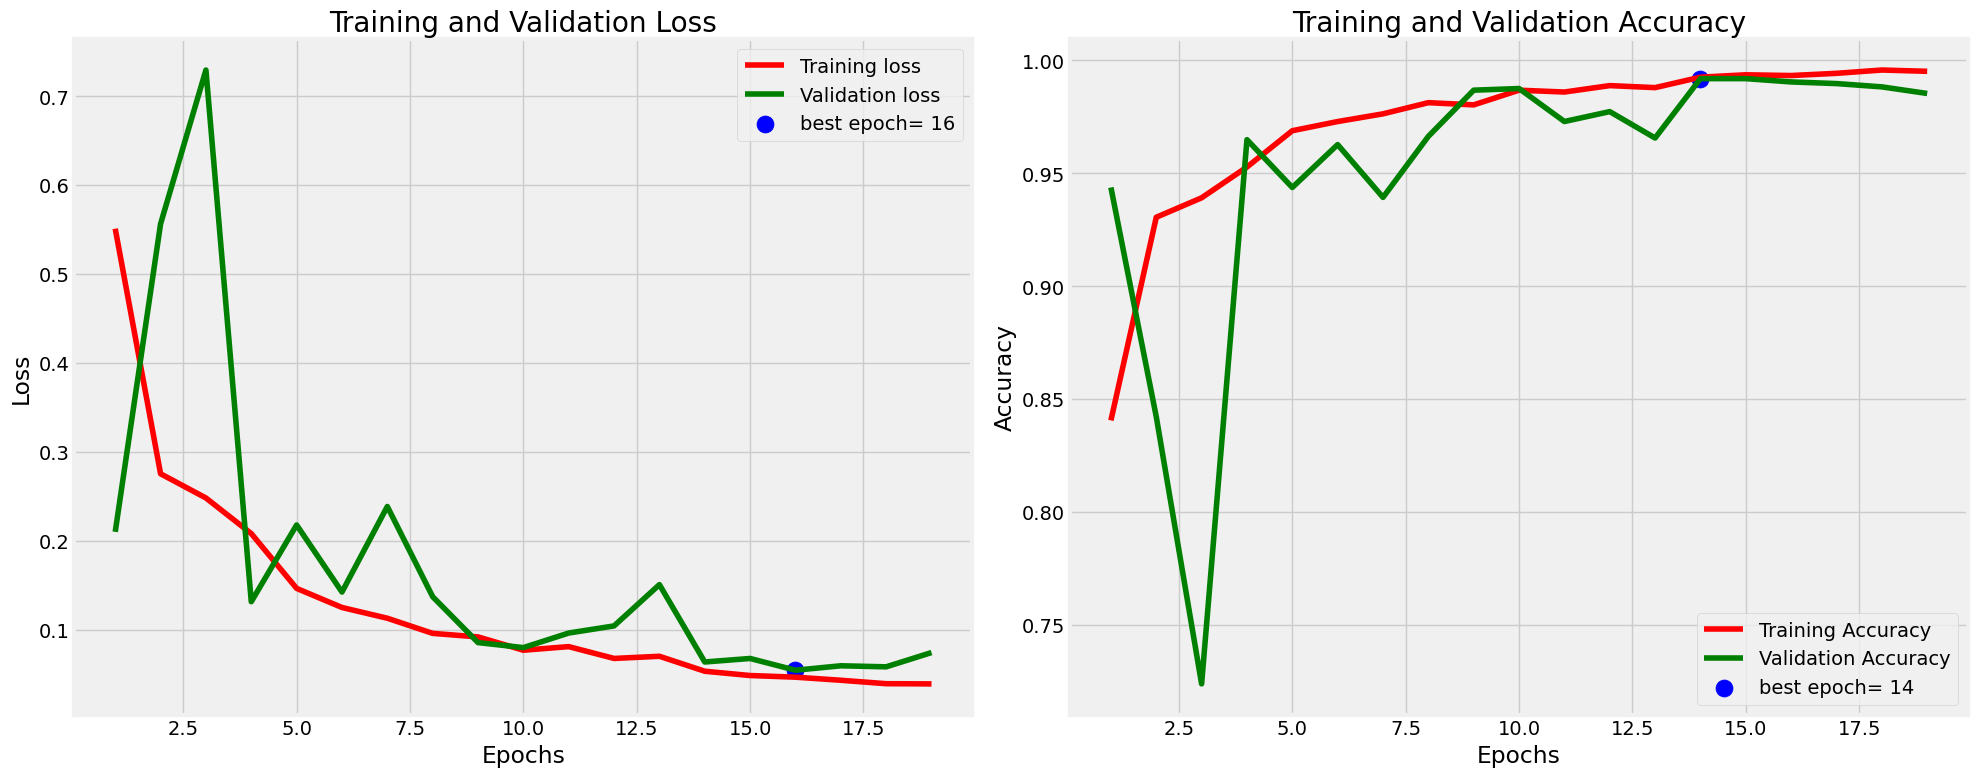

In [22]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',              # 🔁 name of the column with image file paths
    y_col='labels',                 # 🔁 name of the column with labels (optional for prediction only)
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical',      # use 'input' if no labels (for prediction)
    shuffle=False
)


Found 3419 validated image filenames belonging to 8 classes.


In [25]:
ts_length = len(test_df)
test_batch_size = 32


train_steps = train_gen.samples // train_gen.batch_size
val_steps = val_gen.samples // val_gen.batch_size
test_steps = test_gen.samples // test_gen.batch_size

train_score = model.evaluate(train_gen, steps=train_steps, verbose=1)
valid_score = model.evaluate(val_gen, steps=val_steps, verbose=1)
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)


print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1]) 
print('-' * 20) 
print("Test Loss: ", test_score[0]) 
print("Test Accuracy: ", test_score[1]) 

384/384 ━━━━━━━━━━━━━━━━━━━━ 264s 687ms/step - accuracy: 0.9965 - loss: 0.0414
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.9866 - loss: 0.0891
106/106 ━━━━━━━━━━━━━━━━━━━━ 26s 247ms/step - accuracy: 0.9867 - loss: 0.0674
Train Loss:  0.04112076386809349
Train Accuracy:  0.996337890625
--------------------
Validation Loss:  0.06384705752134323
Validation Accuracy:  0.991815447807312
--------------------
Test Loss:  0.07654619216918945
Test Accuracy:  0.9846698045730591


In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Predict on test data
y_pred_probs = model.predict(test_gen, steps=test_steps, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. True labels from test generator
y_true = test_gen.classes  # This works if test_gen was created with class_mode='categorical'

# 3. Class labels (optional, but helpful)
class_labels = list(test_gen.class_indices.keys())

# 4. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 5. Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


NameError: name 'model' is not defined